# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version.

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have.


In [5]:
import numpy as np
from scipy.stats import bernoulli
from numpy.linalg import norm, pinv
from math import log
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
colors = sns.color_palette('colorblind')

# Some reminders 

The (expected) cumulative regret of a strategy $\mathcal{A}=(A_t)_{t\in \mathbb{N}^*}$ is defined as $$\mathcal{R}_T(\mathcal{A}) = \mathbb{E}\left[\sum_{t=1}^{T} (\mu^\star - \mu_{A_t})\right].$$

The random quantity inside the expectation is the cumulative regret on one simulation (sometimes called pseudo-regret), ${R}_T(\mathcal{A}) = \sum_{t=1}^{T} (\mu^\star - \mu_{A_t})$. 

We have : $ R(T) = T \mu _{a^*} - \mathbb{E} \left[ \sum \displaystyle _{t = 1} ^T  X_t \right] = \sum \displaystyle _{a = 1} ^K \Delta _a \mathbb{E} \left[ N_a (T) \right] $,  where $N_a (t)$ is number of times the arm $a$ has been pulled up to time $t$.

## What about Linear Bandits ? 

Unknown parameter: $\mu^* \in \mathbb{R}^d$.

At each time step $t = 1, \dots, T$:

- the environment chooses $K_t \subset \mathbb{R}^d$, the decision set;
- the player chooses an action $x_t \in K_t$;
- given $x_t$, the environment draws the reward $X_t = x_t^\top \mu^* + \varepsilon_t$ , where $\varepsilon_t$ is i.i.d. 1-subgaussian noise $(\forall \lambda > 0, \mathbb{E}[\exp(\lambda \varepsilon_t)] \leq \exp(\lambda^2 / 2))$.
- the player only observes the feedback $X_t$.

The player wants to minimize its expected regret defined as : $ \mathbb{E}[R_T] = \mathbb{E}\left[\sum_{t=1}^T \max_{x \in K_t} x^\top \mu^* - x_t^\top \mu^*\right]$.

In [6]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

# Environment Class

The environment class allows to create 3 types of linear bandit problems:
* 'fixed': normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'iid': at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

### Action generators
Please implement a function that generates K actions in dimension d. You may want to check the lecture slides to see whether some conditions should be respected.

In the report, explain and justify your choice.

In [7]:
def ActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    actions = np.random.randn(K, d)
    actions /= np.linalg.norm(actions, axis=1, keepdims=True)
    return actions


### Linear Bandit environment

The following class is your environment: it generates an action set of K vectors at each round and returns the (random) reward given an action.
You can see how it is used in the experiment function further below.

In [34]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions = None):
      """
      theta: d-dimensional vector (bounded) representing the hidden parameter
      K: number of actions per round (random action vectors generated each time)
      pb_type: string in 'fixed', 'iid', 'nsr' (please ignore NotSoRandom)
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)
      self.fixed_actions = fixed_actions


    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d. Use your ActionsGenerator
      Alternatively, the set of actions is fixed a priori (given as input).
      Implement a condition to return the fixed set when one is given
      """
      if self.fixed_actions is None or not self.fixed_actions.size:
        self.current_action_set = ActionsGenerator(self.K, self.d)
      else:
        self.current_action_set = self.fixed_actions
      return self.current_action_set


    def get_reward(self, action):
      """ sample reward given action and the model of this bandit environment
      action: d-dimensional vector (action chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      return np.dot(self.current_action_set, self.theta)
    
    def reset(self):
        """
        Reset the environment for a new simulation or episode.
        If the environment is IID, regenerate the action set.
        """
        if self.fixed_actions is None:
            # Regenerate the action set if IID (random actions at each round)
            self.current_action_set = ActionsGenerator(self.K, self.d)
        else:
            # If fixed actions, just reset to the predefined set
            self.current_action_set = self.fixed_actions


In [9]:
# Let's test the environment

theta, K = np.array([2., 1., 3., 4.]), 6
theta /= np.linalg.norm(theta)
env = LinearBandit(theta, K)
actions = env.get_action_set()
print("The set of actions is : \n", actions)
for action in actions: 
    print("The reward for action ", action, " is ", env.get_reward(action))
print("Expected rewards:", env.get_means())

The set of actions is : 
 [[-0.22625888  0.8874855   0.08906605 -0.39146348]
 [-0.0872593   0.60745547  0.77282542 -0.16163087]
 [-0.18421349  0.29510852  0.60309856  0.71780811]
 [-0.22951119  0.33730102  0.62737994  0.66328504]
 [ 0.1048314  -0.41447964 -0.35028936 -0.83337529]
 [-0.23662716 -0.19647465  0.7530397  -0.58166701]]
The reward for action  [-0.22625888  0.8874855   0.08906605 -0.39146348]  is  -1.9955597669828
The reward for action  [-0.0872593   0.60745547  0.77282542 -0.16163087]  is  -0.3387243232430027
The reward for action  [-0.18421349  0.29510852  0.60309856  0.71780811]  is  3.121989806348412
The reward for action  [-0.22951119  0.33730102  0.62737994  0.66328504]  is  0.7558533047598287
The reward for action  [ 0.1048314  -0.41447964 -0.35028936 -0.83337529]  is  -0.4878202951385922
The reward for action  [-0.23662716 -0.19647465  0.7530397  -0.58166701]  is  -1.223376763648603
Expected rewards: [-0.15768714  0.38429851  0.84115755  0.80580187 -0.83786691 -0.1346

# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [10]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        environment.reset()    # if the environment is iid, reset it ; otherwise we have the same action set
        agent.reset()
        parameter_T = False

        if agent.name().split('(')[0] in ['LinESGD', 'LinEGreedy']:
           parameter_T = True

        for t in range(T):
            action_set = environment.get_action_set()

            if parameter_T:
               action = agent.get_action(action_set, t)
            else:
                action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              # pseudo-regret removes some of the noise and corresponds to the metric studied in class
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

# Linear Bandit Agents

> Ajouter une citation





## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space.

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement a `LinEpsilonGreedy` agent and test it against `Greedy` ($\epsilon=0$) on the 2 proposed  environments (iid and fixed actions). What do you notice? Is $\epsilon$-Greedy a good baseline to test algorithms?


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards (see course material).

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? Please implement this improvement as an additional option to your `LinUCB` agent so you can compare runtimes from bandit problems in dimension $d=2,8,16,32,64$. Plot the result of the compared runtimes. In your report,  discuss the computational complexity of this step and the resulting improvement, give your new update formula, and report the plot of compared runtimes.

### Uniform random policy

In [11]:
class LinUniform:
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  def name(self):
    return 'Unif'


### Lin-$\epsilon$-Greedy policy:

> This code defines the basic structure of the Linear Epsilon-Greedy algorithm, where an agent decides whether to explore or exploit based on the epsilon value.

For  $t = 1, ..., K$ :

$ a_t = t $     # explore the K actions 

For $t > K$: 

with proba $\epsilon_t$, $ a_t \sim \mathcal{U}(\left[ K \right])$   #explore
    
with proba $1 - \epsilon_t$, compute the following estimator $ \hat{\theta} _t = \underset{ \theta \in \mathbb{R} ^d}{\text{ argmin }} \displaystyle \sum _{s=1} ^{t-1} (X_s - a_s ^T \theta) ^2$   and then put $a_t = \underset{a \in \mathcal{A}}{\text{ argmax }} a^T \hat{\theta} _t$

We know from our statistics lesson that : $\hat{\theta} _t = \left[ \displaystyle \sum _{i=1} ^{t-1} a_s a_s^T \right]^{-1} \displaystyle \sum _{i=1} ^{t-1} a_s X_s$ (or $\hat{\theta} _t = \left[ \displaystyle \sum _{i=1} ^{t-1} a_s a_s^T  + \lambda \textbf{I}_d \right]^{-1} \displaystyle \sum _{i=1} ^{t-1} a_s X_s$ for the regularized version.)


#### Using gradient descent 

The goal is to minimize the following loss function with a regularization term:

$ L(\theta) = \frac{1}{2} \sum_{i=1}^{t} \left( \mathbf{a}_i^\top \theta - X_i \right)^2 + \frac{\lambda}{2} \|\theta\|^2$

where:
 
- $\mathbf{a}_i$ is the $i$-th action vector,

- $X_i$ is the reward received for action $\mathbf{x}_i$,

- $\lambda$ is the regularization parameter.


The gradient of the loss with respect to $\theta$ is:

$ \nabla_\theta L(\theta) = \sum_{i=1}^{t} \left( \mathbf{a}_i^\top \theta - X_i \right) \mathbf{x}_i + \lambda \theta $

Using stochastic gradient descent (SGD), the update rule for $\theta$ is:

$ \theta \leftarrow \theta - \eta \left( \left( \mathbf{a}_t^\top \theta - X_t \right) \mathbf{a}_t + \lambda \theta \right) $

where:
- $\eta$ is the learning rate,

- $\mathbf{a}_t$ is the action vector at time step $t$,

- $X_t$ is the reward at time step $t$.

In [12]:
class LinEpsilonGreedy:
  def __init__(self, d, lambda_reg,m = 1, eps = 0.1, SGD_Up = False, FixedEpsilon = False, other_option = None):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.SGD_Up = SGD_Up
    self.m = m
    self.FixedEpsilon = FixedEpsilon
    self.reset()

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.ones(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms, t):
    K, _ = arms.shape
    if t < self.m * K:     # play each arm once (exploration)
      index = t % K
      return arms[index]
    else:
      expl = np.random.random()
      if self.FixedEpsilon:
        self.eps = np.min(1, (K) / (self.t * (self.d ** 2)))
      if expl < self.eps:
        action = arms[np.random.randint(K)]
      else:
        index = np.argmax([np.dot(arm, self.hat_theta) for arm in arms])
        action = arms[index]
      return action

  def receive_reward(self, chosen_arm, reward, eta = 0.01):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    if self.SGD_Up:
      error = np.dot(chosen_arm, self.hat_theta) - reward
      update = np.dot(chosen_arm, error) + self.lambda_reg * self.hat_theta
      self.hat_theta -= eta * update
    else:
      #update inverse covariance matrix
      self.cov += np.outer(chosen_arm, chosen_arm)
      self.invcov = pinv(self.cov)


      #update b_t
      self.b_t += reward * chosen_arm

      self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1

  def name(self):
    if self.SGD_Up:
      return 'LinESGD(eps = '+str(self.eps)+', m = '+str(self.m)+')'
    else:
      return 'LinEGreedy('+str(self.eps)+', m = '+str(self.m)+')'



### Default setting

Quick test: I propose some simple settings to run a quick test.
For your report, feel free to change these and explain / justify your choices.
Please report the resulting plot and your conclusions on Lin-E-Greedy.

In [29]:
d = 10  # dimension
K = 10  # number of arms

# parametor vector \theta, normalized :
# theta = ActionsGenerator(1,d) # another way of getting a 'random vector' (depends on your implementation)
theta = np.array([0.45, 2.5, 0.5, 5.0, 3.2, 0.45, 2.5, 0.5, 5.0, 3.2])
theta /= np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 100  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 0.01


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


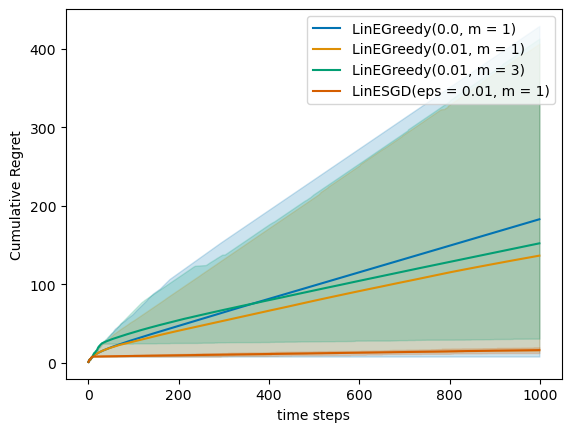

In [30]:
# Fixed environment for all agents
env = LinearBandit(theta, K, var = sigma**2, fixed_actions = ActionsGenerator(K,d))
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.01)
e_greedy_3 = LinEpsilonGreedy(d, lambda_reg = 1., m = 3, eps = 0.01)
e_greedy_fixed = LinEpsilonGreedy(d, lambda_reg = 1., FixedEpsilon = True)
e_greedy_SGD = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.01, SGD_Up = True)
greedy = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.)

exp = experiment(environment = env,
                agents = [greedy, e_greedy, e_greedy_3, e_greedy_SGD],  #Uniform not usefull ...
                Nmc = N, 
                T = T,
                pseudo_regret = True)
plot_regret(exp)

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


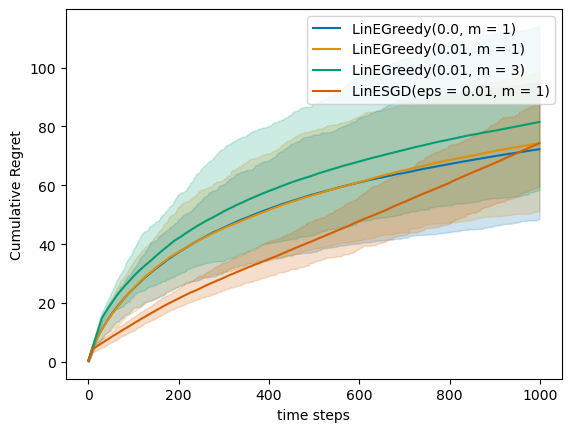

In [31]:
# IID environment for all agents
env = LinearBandit(theta, K, var = sigma ** 2, fixed_actions = None)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.01)
e_greedy_3 = LinEpsilonGreedy(d, lambda_reg = 1., m = 3, eps = 0.01)
e_greedy_SGD = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.01, SGD_Up = True)
e_greedy_fixed = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.01, FixedEpsilon = True)
greedy = LinEpsilonGreedy(d, lambda_reg = 1., eps = 0.)

exp = experiment(environment = env,
                agents = [greedy, e_greedy, e_greedy_3, e_greedy_SGD], 
                Nmc = N, 
                T = T,
                pseudo_regret = True)
plot_regret(exp)

Is Lin-E-Greedy a strong baseline? Is it hard to beat?

## Lin-UCB: The optimistic way

**Implement LinUCB** as seen in class and test it against the baselines implemented above.

If you are happy with the result, move to the last part below.

### Algorithm : LinUCB

Assuming that the noise $ \epsilon _t $ are $ \sigma ^{2} $-sub-Gaussian, and that for all $t$ and $a \in \mathcal{A} _t, || a || \leq L$, we have the following algorithm : 

#### INPUT : 
- $\space \space \space \space \space $ probability $ \delta $
- $\space \space \space \space \space $ dimension $d $
- $\space \space \space \space \space $ regularization parameter $ \lambda $

#### INITIALIZATION : 
- $\space \space \space \space \space $ $b = \mathbf{0} _{\mathbb{R} ^d}$ 
- $\space \space \space \space \space $ $ V = \lambda \mathbf{I} _d $
- $\space \space \space \space \space $ $  \hat{ \theta } = \mathbf{0} _{\mathbb{R} ^d}$ 

#### For $t \geq 1$, do: 

$\space \space \space \space \space $ Receive $ \mathcal{A} _t$ and compute $ \beta _{t-1} = \sigma \sqrt{ 2 \log \left(\frac{1}{\delta}\right) + d \log \left(1 + \frac{t L}{d \lambda }\right)} + \sqrt{\lambda} \|\theta^\star\| $

$\space \space \space \space \space $ For $ a \in \mathcal{A} _t$ do 

$\space \space \space \space \space $  $\space \space \space \space \space $ compute UCB(a) = $ a ^{T} \hat{ \theta } + \beta _{t-1} \sqrt{a ^{T} V ^{-1} a}$

$\space \space \space \space \space $ $A_t = \underset{ a \in \mathcal{A} _t}{\text{ argmax }} ( \text{UCB} (a))$

$\space \space \space \space \space $ Play action $A_t $ and receive reward $X_t$

$\space \space \space \space \space $ Updating phase : 
- $\space \space \space \space \space $ $\space \space \space \space \space $ $ V = V + A_t A_t ^{T}$
- $\space \space \space \space \space $ $\space \space \space \space \space $ $ b = b + X_t A_t $
- $\space \space \space \space \space $ $\space \space \space \space \space $ $ \hat{ \theta } = V ^{-1} b$

#### END


In [16]:
# We assume that the Epsilon_t are N(0,1) distributed so 1-subgaussian : sigma = 1
# We also assume that actions are bounded in the unit sphere so L = 1
class LinUCB:
    def __init__(self, d, lambda_reg, delta = 0.1, sigma = 1., L = 1.):
        self.d = d
        self.lambda_reg = lambda_reg
        self.delta = delta
        self.sigma = sigma
        self.L = L
        self.reset()

    def reset(self):
        self.t = 0
        self.hat_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = (1 / self.lambda_reg) * np.identity(self.d)
        self.b_t = np.zeros(self.d)

    def beta(self):
        return self.sigma * np.sqrt(
            2 * np.log(1 / self.delta) + self.d * np.log(1 + self.t * ((self.L) / (self.d * self.lambda_reg)))
            ) + np.sqrt(self.lambda_reg) * norm(self.hat_theta)

    def UCB(self, a):
        self.b_t = self.beta()
        return np.dot(a, self.hat_theta) + self.b_t * np.sqrt(np.dot(a, np.dot(self.invcov, a)))

    def get_action(self, arms):
        K, _ = arms.shape
        UCB = np.zeros(K)
        for k in range(K):
            a = arms[k]
            UCB[k] = self.UCB(a)
        A_t = arms[np.argmax(UCB)]
        return A_t
    
    def receive_reward(self, chosen_arm, reward):
        self.cov += np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)    # update inverse covariance matrix
        self.b_t += reward * chosen_arm
        self.hat_theta = np.inner(self.invcov, self.b_t)    # update the least square estimate
        self.t += 1
    
    def name(self):
        return 'LinUCB'

### Test against baselines

In [17]:
# policies
env = LinearBandit(theta, K, var = sigma**2, fixed_actions = None)    # IID environment for all agents
linucb = LinUCB(d, lambda_reg = 1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


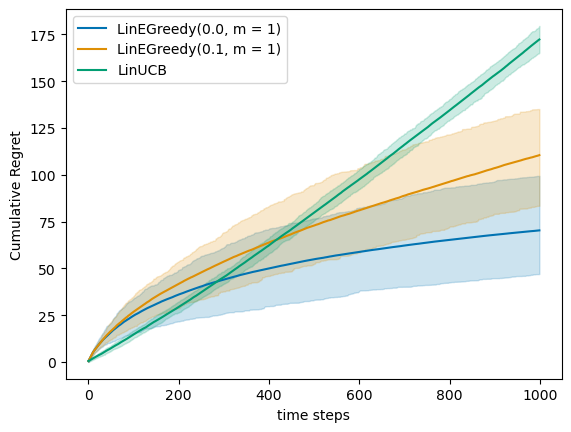

In [18]:
linucb_vs_greedy = experiment(env, [greedy, e_greedy, linucb], Nmc = N, T = T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

In your report, write the distribution of the posterior as a function of the prior and the observed data. No need to report your full derivation if you are lacking space.


* **Implementation of LinTS**. Please implement Linear Thompson Sampling using the formula you derived above.


Our Bayesian model is the following : 
- likelihood : $ Y_t = \theta_* ^T A_t + \epsilon_t$ and we assume that $ \epsilon_t \sim \mathcal{N} (0, \sigma ^2 )$
- prior : $\theta _* \sim \mathcal{N} (0, \lambda \textbf{I}_d)$

Using a gaussian noise allows us to have a closed form the posterior : 

$$ \theta _* | A_1, Y_1, ..., A_t, y_t \sim \mathcal{N} ( \hat{ \theta} ^{\lambda} _t , \sigma ^2 (B _t ^{ \lambda} ) ^{-1} )$$ 

where , $B _t ^{ \lambda } = \lambda \textbf{I}_d + \displaystyle \sum _{i=1} ^t A_i A_i ^T$ and $ \hat{ \theta} ^{\lambda} _t = (B _{t} ^{ \lambda} ) ^{-1} \displaystyle \sum _{i=1} ^t Y_i A_i $


Then, the algorithm is : 

In each round $t+1$ : 
- $\theta _t \sim \mathcal{N} ( \hat{ \theta} ^{\lambda} _t , \sigma ^2 (B _t ^{ \lambda} ) ^{-1} )$
- $A_{t+1} = \underset{ a \in \mathcal{A} _{t+1}}{\text{ argmax }} a ^T \theta _t$

In [19]:
class LinTS:
    def __init__(self, d, lambda_reg, sigma = 1.):
        self.d = d
        self.lambda_reg = lambda_reg
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.t = 0
        self.cov = self.lambda_reg * np.identity(self.d)
        self.mean = np.zeros(self.d)
        self.hat_theta = np.random.multivariate_normal(self.mean, self.cov)   # prior 

    def update_theta(self, chosen_arm, reward):
        previous_cov = self.cov 
        B_t = pinv(previous_cov / self.sigma)
        previous_sum = B_t @ self.mean
        B_t += np.outer(chosen_arm, chosen_arm)
        inv_B = pinv(B_t)
        self.cov = inv_B * self.sigma
        new_sum = previous_sum + reward * chosen_arm
        self.mean = inv_B @ new_sum
        self.hat_theta = np.random.multivariate_normal(self.mean, self.cov)    # posterior

    def get_action(self, arms):
        K, _ = arms.shape
        vector = [np.dot(action, self.hat_theta) for action in arms]
        chosen_arm = arms[np.argmax(vector)]
        return chosen_arm
    
    def receive_reward(self, chosen_arm, reward):
        reward = np.dot(chosen_arm, self.hat_theta)
        self.update_theta(chosen_arm, reward)
        self.t += 1
    
    def name(self):
        return 'LinTS'


### Comparison and report

Compare LinUCB, LinTS and LinEGreedy on a problem of your choice. In your report, explain your choice of problem and report the plot of your experiment as well as a few sentences of comment: Is there a clear 'winner'?

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


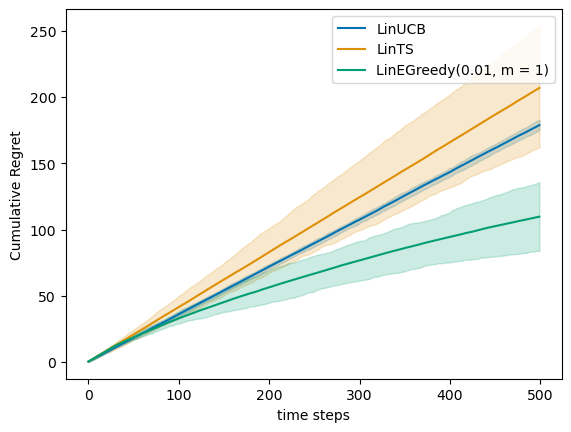

In [20]:
d = 25  # Dimension of actions
K = 30  # Number of actions per round
T = 500  # Time horizon
Nmc = 50  # Number of Monte Carlo runs


true_theta = np.random.uniform(-1, 1, size=d)
true_theta /= np.linalg.norm(true_theta)  


environment = LinearBandit(theta = true_theta, 
                           K = K,
                           fixed_actions = None)


lambda_reg = 1.0  # Regularization parameter
linucb_agent = LinUCB(d = d, lambda_reg = lambda_reg)
lints_agent = LinTS(d = d, lambda_reg = lambda_reg)
linegreedy_agent = LinEpsilonGreedy(d, lambda_reg = lambda_reg, eps=0.01) 

# Run experiment
agents = [linucb_agent, lints_agent, linegreedy_agent]
results = experiment(environment, agents, Nmc, T)

plot_regret(results)


#Bonus

In this bonus part, we explore the role of the action sets on the performance of our algorithms.

In class we said that action sets can be 'arbitrary'. This means that, in principle, they do not have to follow a distribution, they do not have to be random either.

What happens if the action set is fixed?

We propose an alternative 'play' function that fixes the action set:

In [21]:
def play_fixed(environment, agent, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    actions: a fixed action set. Default is set to be the canonical basis.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            # action_set = environment.get_action_set() -> We no longer call on your ActionsGenerator function
            action_set = np.copy(actions) # the actions given as input
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data

In [22]:
def experiment_fixed(environment, agents, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}
    if actions is None:
      actions = ActionsGenerator(K,d) #call it once!
    print(actions)

    for agent in agents:
        agent_id, regrets = play_fixed(environment, agent, Nmc, T, actions=actions, pseudo_regret=pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

Now the actions are fixed, so we could actually use UCB to address the problem: after all, it is just a K-armed bandit, but with structure.

**When is LinUCB better than UCB?**

In [23]:
class UCB:
  def __init__(self, K, var):
      self.K = K
      self.var = var
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def get_action(self,action_set):
      if self.t < self.K:
        action = self.t
      else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(6 * self.var * np.log(self.t) / self.count_actions) # 6 could be replaced by a 2, try it out :)
        action = np.argmax(empirical_means + ucbs)

      self.t += 1
      self.count_actions[action] += 1
      self.current_action = action #need to remember the *index* of the action now
      return action_set[action,:]

  def receive_reward(self, action, reward):
      self.count_rewards[self.current_action] += reward

  def reset(self):
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def name(self):
      return 'UCB('+str(self.var)+')'

In [35]:
d=3
K=7 # same as before, more actions than dimension
theta = np.linspace(0.1,1,num=d)
env = LinearBandit(theta, K)
ucb = UCB(K,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=None, pseudo_regret=True)

[[ 0.42074523  0.40269918 -0.81290026]
 [-0.93864551 -0.13299655 -0.31820829]
 [-0.65166329  0.58073268  0.48793904]
 [ 0.50849105 -0.23536579  0.82827519]
 [ 0.19180961  0.66870481 -0.7183613 ]
 [-0.67604992 -0.39442394 -0.62240361]
 [ 0.76244918  0.46146609 -0.453564  ]]


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


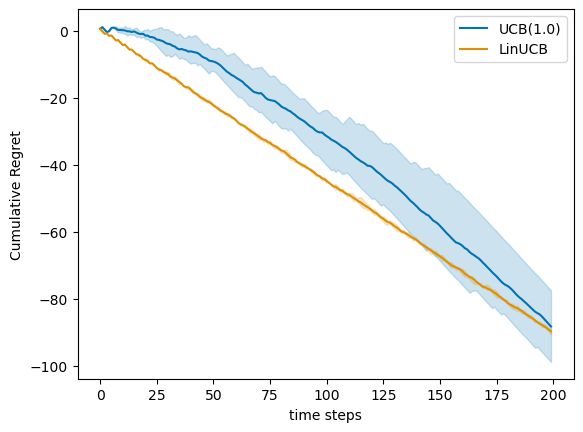

In [36]:
plot_regret(reg_fixed_actions)

In general, LinUCB is better in such problem because it shares information across actions.

Now, what if K=d and the fixed action set is exactly the canonical basis (K=d independent actions)

In [37]:
d=7
K=d
# theta = np.random.multivariate_normal(np.zeros(d),np.eye(d))
theta = np.linspace(0.1,1,num=d) # just d actions in increasing value order
#theta = your choice of parameter
theta /= np.linalg.norm(theta) #optional if you set theta with bounded norm :)

env = LinearBandit(theta, d, fixed_actions=np.eye(d))
ucb = UCB(d,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=np.eye(d), pseudo_regret=True)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_4930/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


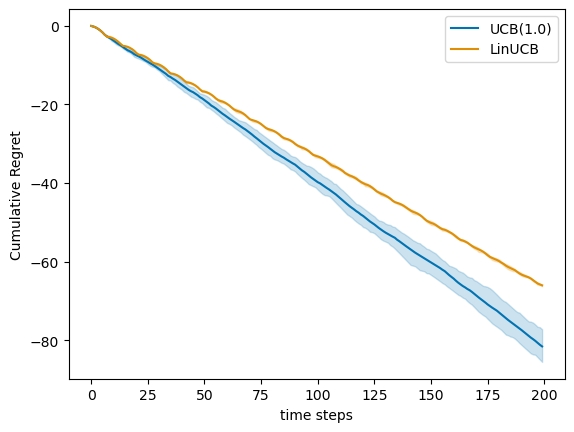

In [38]:
plot_regret(reg_fixed_actions)

The two algorithms should be roughly on par. In fact, it is possible to refine UCB to get slightly better performance (by tightening a bit the upper confidence bounds).

In "[The End of Optimism](https://arxiv.org/pdf/1610.04491)", Lattimore et al. show that for a certain type of action set, one can show that UCB has **linear regret**. A famous 'counter-example' (bad action set) is given in Section 8 therein.

**Exercise**: find the action set (3 actions in dimension 2) and run the experiment above, what do you see? In (the appendix of) your report, please report your figures and conclusions.

The problem of finding a good algorithm for the 'arbitrary' setting and the 'fixed-design' setting was open for a long time but recent papers (e.g. [Kirschner et al.,2021](https://arxiv.org/abs/2011.05944)) have now proposed solutions.

In [ ]:
K = 3
d = 2